<a href="https://colab.research.google.com/github/19-ade/UCI_data-/blob/main/UCI_data_22_06_22_FirstModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Accelerometer Biometric data and analysis [Link to Data](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer#)
---



In [ ]:
! pip install torchlibrosa
! pip install pytorch_lightning


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation
from collections import Counter, defaultdict
import matplotlib.pyplot as plt 
import pytorch_lightning as pl
import os 
import scipy 
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchmetrics import Accuracy
import copy

#from pytorch_lightning.metrics.functional import accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
''' Rules: ( see Manual.txt)

Type:		   tri-axial accelerometer
Measurement range: [- 1.5g; + 1.5g]
Sensitivity: 	   6 bits per axis
Output data rate:  32 Hz
Location:	   attached to the right wrist of the user with:
		   - x axis: pointing toward the hand
		   - y axis: pointing toward the left
		   - z axis: perpendicular to the plane of the hand


Acceleration data recorded in the dataset are coded according to the following mapping:
	[0; +63] = [-1.5g; +1.5g]
The conversion rule to extract the real acceleration value from the coded value is the following:
	real_val = -1.5g + (coded_val/63)*3g


Each file in the dataset follows the following naming convention:
Accelerometer-[START_TIME]-[HMP]-[VOLUNTEER]
where:
- [START_TIME]: timestamp of the starting moment of the recording
		in the format [YYYY-MM-DD-HH-MM-SS]
- [HMP]:	name of the HMP performed in the recorded trial, following
		the naming convention specified in Section 2 of this manual
- [VOLUNTEER]:	identification code of the volunteer performing the recorded
		motion in the format [gN] where:
		- "g" indicates the gender of the volunteer
		  (m -> male, f -> female)
		- "N" indicates the progressive number associated to the
		  volunteer

For example the file:
	Accelerometer-2011-03-24-10-24-39-climb_stairs-f1.txt
refers to an accelerometer recording that was taken on March 24, 2011, starting from 10:24.39 a.m.. 
The recording refers to the HMP "climb_stairs" executed by the volunteer with ID "f1".



'''
PATH = "/content/gdrive/MyDrive/UCI_data /HMP_Dataset/dataset.csv"

class Make_DataFrame:
  def __init__(self):
    self.df = pd.DataFrame()

  def col_identifier(self, file_name):
    # extracting the class and subject_id from 
    # file name
    name_ls = file_name.split('/')[-1].split('-')
    cl = name_ls[-2]
    v_id = name_ls[-1].split('.')[0]
    date_starting_time = "-".join(name_ls[1:-2])
    return (v_id, cl, date_starting_time)
  
  def dataframe_maker(self, file_name):
    # Reading the files 
    df1 = pd.read_csv(file_name, sep = " ", header = None, names = ['X', 'Y',
                                                                    'Z'])
    # Adding the id, class and date columns
    col_return = self.col_identifier(file_name)
    df1[['subject_id', 'cat', 'date_time']] = [col_return[0], col_return[1],
                                                     col_return[2]]
    
    # Converting acc data to acceleration
    df1.X = self.calc_acc(df1.X.values)
    df1.Y = self.calc_acc(df1.Y.values)
    df1.Z = self.calc_acc(df1.Z.values)

    # Appending to dataframe object
    if len(self.df)==0: # improve this code (if df: )
      self.df = df1
    else:
      self.df = self.df.append(df1, ignore_index=True)

  def calc_acc(self, data):
    # calculating the acceleration form the 
    return -14.709 + (data/63)*(2*14.709)

  def store_file(self):
    # save the dataset as csv in gdrive
    with open(PATH, 'w', encoding = 'utf-8-sig') as f:
      self.df.to_csv(f, index_label=False)

  


In [ ]:
# looping over the folders 
# extracting classes and data 

DIR_LOC = "/content/gdrive/MyDrive/UCI_data /HMP_Dataset"
a = Make_DataFrame()
for folder in os.listdir(DIR_LOC):
  if folder.split('_')[-1] == 'MODEL':
    continue
  else:
    file_list_loc = DIR_LOC + "/" + folder
    print(file_list_loc)
    for file in os.listdir(file_list_loc):
      a.dataframe_maker(file_list_loc+"/"+file)
      #print(a.df)

/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Pour_water
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Climb_stairs
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Sitdown_chair
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Use_telephone
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Walk
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Standup_chair
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Descend_stairs
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Brush_teeth
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Liedown_bed
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Eat_meat
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Drink_glass
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Getup_bed
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Comb_hair
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/Eat_soup
/content/gdrive/MyDrive/UCI_data /HMP_Dataset/.ipynb_checkpoints


In [ ]:
a.df.head()

,X,Y,Z,subject_id,cat,date_time
0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2.568238,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
3,2.101286,5.836905,8.638619,f1,pour_water,2011-03-24-10-51-12
4,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12


In [ ]:
# save the file in the gdrive folder

a.store_file()

In [ ]:
# load dataset from folder 
PATH_TO_DATASET = '/content/gdrive/MyDrive/UCI_data /HMP_Dataset/dataset.csv' # change this 

df1 = pd.read_csv(PATH_TO_DATASET)
df1.subject_id.unique()

array(['f1', 'm2', 'f4', 'm1', 'm9', 'f2', 'm3', 'f3', 'm4', 'm11', 'm5',
       'm6', 'm7', 'm8', 'm10', 'f5'], dtype=object)

In [ ]:
df1.head()

,X,Y,Z,subject_id,cat,date_time
0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2.568238,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
3,2.101286,5.836905,8.638619,f1,pour_water,2011-03-24-10-51-12
4,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12


In [ ]:
df1.cat.unique()

array(['pour_water', 'climb_stairs', 'sitdown_chair', 'use_telephone',
       'walk', 'standup_chair', 'descend_stairs', 'brush_teeth',
       'liedown_bed', 'eat_meat', 'drink_glass', 'getup_bed', 'comb_hair',
       'eat_soup'], dtype=object)

In [ ]:
for i in df1.columns:
  print(df1[i].isna().sum())

0
0
0
0
0
0


In [ ]:
df1.describe()

,X,Y,Z
count,446529.000000,446529.000000,446529.000000
mean,-3.188558,3.137682,4.828214
std,5.677017,3.591185,3.877309
min,-14.709000,-14.709000,-14.709000
25%,-8.638619,1.634333,1.634333
50%,-3.035190,3.035190,4.903000
75%,1.167381,4.903000,8.638619
max,14.709000,14.709000,14.709000


In [ ]:
df1.describe

<bound method NDFrame.describe of                X         Y         Z subject_id         cat  \
0       2.101286  5.836905  7.704714         f1  pour_water   
1       2.101286  5.836905  7.704714         f1  pour_water   
2       2.568238  5.369952  8.171667         f1  pour_water   
3       2.101286  5.836905  8.638619         f1  pour_water   
4       2.101286  5.369952  8.171667         f1  pour_water   
...          ...       ...       ...        ...         ...   
446524  1.634333  7.704714  6.770810         f1    eat_soup   
446525  1.634333  7.704714  6.770810         f1    eat_soup   
446526  1.634333  6.770810  6.303857         f1    eat_soup   
446527  1.634333  7.237762  6.770810         f1    eat_soup   
446528  1.634333  8.171667  6.770810         f1    eat_soup   

                  date_time  
0       2011-03-24-10-51-12  
1       2011-03-24-10-51-12  
2       2011-03-24-10-51-12  
3       2011-03-24-10-51-12  
4       2011-03-24-10-51-12  
...                     ...  

In [ ]:
# stat calc and display

def print_seq_len(df):
  for i in df.cat.unique():
    c = len(df[df['cat']==i]['date_time'].unique())
    print(f"class:{i}, length:{c}")

def basic_stats(df):
  l = []
  c = {key: None for key in df.cat.unique()}
  for i in df.date_time.unique():
    l.append(len(df[df['date_time']==i]))
    cat = df[df['date_time']==i]['cat'].unique()[0]
    if c[cat]==None:
      c[cat] = [len(df[df['date_time']==i])]
    else:
      c[cat].append(len(df[df['date_time']==i]))
  print("Sequence: \n")
  print(f"Avg length : {np.mean(l):.2f}")
  print(f"Max length : {np.max(l)}")
  print(f"Min length : {np.min(l)}")
  print(f"Median length : {np.median(l)}\n")

  print("Cat: \n")
  for key, value in c.items():
    print(f"Cat: {key}")
    print(f"Mean: {np.mean(c[key]):.2f}, Max: {np.max(c[key])}, MIn: {np.min(c[key])}, Median: {np.median(c[key])}")



In [ ]:
# STATS BEFORE 

# seq lengths class-wise
print_seq_len(df1)
# basic stats 
basic_stats(df1)



class:pour_water, length:100
class:climb_stairs, length:102
class:sitdown_chair, length:100
class:use_telephone, length:13
class:walk, length:100
class:standup_chair, length:102
class:descend_stairs, length:42
class:brush_teeth, length:12
class:liedown_bed, length:28
class:eat_meat, length:5
class:drink_glass, length:100
class:getup_bed, length:101
class:comb_hair, length:31
class:eat_soup, length:3
Sequence: 

Avg length : 532.22
Max length : 9318
Min length : 125
Median length : 403.0

Cat: 

Cat: pour_water
Mean: 416.73, Max: 810, MIn: 244, Median: 406.0
Cat: climb_stairs
Mean: 394.69, Max: 805, MIn: 166, Median: 402.5
Cat: sitdown_chair
Mean: 250.36, Max: 691, MIn: 125, Median: 210.0
Cat: use_telephone
Mean: 1171.15, Max: 2857, MIn: 333, Median: 995.0
Cat: walk
Mean: 922.54, Max: 3153, MIn: 187, Median: 914.0
Cat: standup_chair
Mean: 249.19, Max: 545, MIn: 141, Median: 205.5
Cat: descend_stairs
Mean: 366.07, Max: 594, MIn: 156, Median: 363.5
Cat: brush_teeth
Mean: 2485.75, Max: 319

In [ ]:
# CLASS SELECTION 
for i in df1.cat.unique():
  c = len(df1[df1['cat']==i]['date_time'].unique())
  if c<100:
    df1 = df1.drop(df1[df1['cat']==i].index)  # dropping classes with seq count <100
  for j in df1[df1['cat']==i]['date_time'].unique():
    l = len(df1[(df1['cat']==i)&(df1['date_time']==j)])
    if l<256: # dropping sequences with length < 256
      df1 = df1[df1['date_time']!=j]
    else:
      # updating it with first 256 values
      # need better method 
      df1.drop(df1.loc[df1['date_time']==j, :].index[256:], inplace=True)
df1.dropna(how='all')
df1.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df1.dropna(how='all')
df1.reset_index(drop=True, inplace=True)

In [ ]:
df1


,X,Y,Z,subject_id,cat,date_time
0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2.568238,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
3,2.101286,5.836905,8.638619,f1,pour_water,2011-03-24-10-51-12
4,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
...,...,...,...,...,...,...
143867,-6.303857,2.568238,7.237762,f5,getup_bed,2012-06-20-20-30-45
143868,-6.303857,1.634333,6.303857,f5,getup_bed,2012-06-20-20-30-45
143869,-6.303857,2.101286,6.770810,f5,getup_bed,2012-06-20-20-30-45
143870,-6.770810,2.568238,6.303857,f5,getup_bed,2012-06-20-20-30-45


In [ ]:
# STATS AFTER 

# seq lengths class-wise
print_seq_len(df1)
# basic stats 
#basic_stats(df1)


class:pour_water, length:99
class:climb_stairs, length:97
class:sitdown_chair, length:31
class:walk, length:98
class:standup_chair, length:37
class:drink_glass, length:99
class:getup_bed, length:101


In [ ]:
df1[df1['date_time']=='2011-03-24-09-51-07']

,X,Y,Z,subject_id,cat,date_time
58112,0.233476,7.237762,3.969095,f1,walk,2011-03-24-09-51-07
58113,0.233476,7.237762,3.969095,f1,walk,2011-03-24-09-51-07
58114,0.233476,7.704714,2.568238,f1,walk,2011-03-24-09-51-07
58115,-0.233476,6.770810,1.167381,f1,walk,2011-03-24-09-51-07
58116,-1.167381,5.836905,1.167381,f1,walk,2011-03-24-09-51-07
...,...,...,...,...,...,...
58363,-10.506429,2.101286,-0.233476,f1,walk,2011-03-24-09-51-07
58364,-10.039476,1.634333,-0.233476,f1,walk,2011-03-24-09-51-07
58365,-10.039476,1.634333,-0.233476,f1,walk,2011-03-24-09-51-07
58366,-8.171667,2.568238,0.233476,f1,walk,2011-03-24-09-51-07


In [ ]:
''' Characteristics of the data : no sequence starting date and time has been 
repeated. 
Implemented :

Cleaning:
median Filtering 

time domain: 
max
mean
std

freq domain:
FFT 
Spectrogram 
power spectral analysis 

Todo:
select the correct classes for equal time sampling 
Spectroscope : mel filters 
band pass filtering

'''
class PreProcessing:
  def __init__(self, data):
    self.df = data
    self.dev_x_timed = defaultdict(list) # time_data amplitude
    self.dev_y_timed = defaultdict(list)
    self.dev_z_timed = defaultdict(list)
    self.x_fft_cat = defaultdict(list) # fft 
    self.y_fft_cat = defaultdict(list)
    self.z_fft_cat = defaultdict(list)
    self.x_spec_cat = defaultdict(list) # spectroscope data 
    self.y_spec_cat = defaultdict(list)
    self.z_spec_cat = defaultdict(list)
    self.x_PSD_cat = defaultdict(list) # PSD data []
    self.y_PSD_cat = defaultdict(list)
    self.z_PSD_cat = defaultdict(list)

  def plot_data(self,ylabel, xlabel, title, data, typedata="slice", col=""):
    plt.ylim([-15, 15])
    if typedata=='slice':
      plt.xlim([0, len(data)])
      plt.plot(data)
    elif typedata=='sequence':
      plt.xlim([0, len(data[col])])
      plt.plot(data[col].values)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.show()

  def remove_noise(self, data): # applying median filter 
    kernel_size = 3 # size of the filter 
    return scipy.signal.medfilt(data.values, kernel_size = 
                                               kernel_size)

  def sequence_cleaner(self):
    # clean sequence for each cat    
    for i in self.iterator_generator('seq'):
      self.df.loc[self.df['date_time']==i, 'X'] = self.remove_noise(self.df[self.df['date_time']
                                                                   ==i]['X'])
      self.df.loc[self.df['date_time']==i, 'Y'] = self.remove_noise(self.df[self.df['date_time']
                                                                   ==i]['Y'])                                                                      
      self.df.loc[self.df['date_time']==i, 'Z'] = self.remove_noise(self.df[self.df['date_time']
                                                                   ==i]['Z'])
      
  def calc_time_domain(self, sample):
    mean_x, mean_y, mean_z = sample['X'].mean(), sample['Y'].mean(), sample['Z'].mean()
    std_x, std_y, std_z = sample['X'].std(), sample['Y'].std(), sample['Z'].std()
    max_x, max_y, max_z = sample['X'].max(), sample['Y'].max(), sample['Z'].max()
    id = sample.cat.unique()[0]
    self.dev_x_timed[id].append([mean_x, std_x, max_x])
    self.dev_y_timed[id].append([mean_y, std_y, max_y])
    self.dev_z_timed[id].append([mean_z, std_z, max_z])
  
  def calc_fft(self, data):
    
    yf = scipy.fftpack.fft(data.values)
    xf = scipy.fftpack.fftfreq(len(data), d =1/32)
    
    return [yf[:len(xf)//2+1], xf[:len(xf)//2+1]]
  
  def plot_FFT(self, cat, pos, axis):
    if axis=='X':
      xf = self.x_fft_cat[cat][pos][-1]
      yf = self.x_fft_cat[cat][pos][0]
    if axis=='Y':
      xf = self.y_fft_cat[cat][pos][-1]
      yf = self.y_fft_cat[cat][pos][0]
    if axis=='Z':
      xf = self.z_fft_cat[cat][pos][-1]
      yf = self.z_fft_cat[cat][pos][0]
    
    plt.plot(xf, np.abs(yf))
    plt.grid()
    plt.title(cat)
    plt.xlim([0, np.max(xf)])
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency[Hz]');
    plt.show()

  def feature_extraction(self):
    for i in self.iterator_generator('seq'):
      data_X = self.df[self.df['date_time']==i]['X']
      data_Y = self.df[self.df['date_time']==i]['Y']
      data_Z = self.df[self.df['date_time']==i]['Z']
      
      # Time domain 
      self.calc_time_domain(self.df[self.df['date_time']==i])

      #Freq Domain 
      #FFT 
      self.x_fft_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.calc_fft(data_X))
      
      self.y_fft_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.calc_fft(
          data_Y
      ))
      self.z_fft_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.calc_fft(
          data_Z
      ))

      # Spectrogram 
      self.x_spec_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.Spectrogram_maker(data_X))
      self.y_spec_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.Spectrogram_maker(data_Y))
      self.z_spec_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.Spectrogram_maker(data_Z))
      
      # PSD
      self.x_PSD_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.PSD_maker(data_X))
      self.y_PSD_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.PSD_maker(data_Y))
      self.z_PSD_cat[self.df[self.df['date_time']==i]['cat'].unique()[0]].append(self.PSD_maker(data_Z))
      

  def PSD_plotter(self, cat, pos, axis):
    if axis=='X':
      f = self.x_PSD_cat[cat][pos][0]
      Pxx_den = self.x_PSD_cat[cat][pos][-1]
    if axis=='Y':
      f = self.y_PSD_cat[cat][pos][0]
      Pxx_den = self.y_PSD_cat[cat][pos][-1]
    if axis=='Z':
      f = self.z_PSD_cat[cat][pos][0]
      Pxx_den = self.z_PSD_cat[cat][pos][-1]
    
    plt.semilogy(f, Pxx_den)
    plt.grid()
    plt.title(cat)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
  
  def PSD_maker(self, data):
    # change window length to 32
    f, Pxx_den = scipy.signal.welch(data, fs=32, nperseg=128, window = 'hanning')
    return [f, Pxx_den]

  def Spectrogram_maker(self, data):
     # chnage the window lenght to 32 
     freqs, times, Sx = scipy.signal.spectrogram(data, fs=32, window='hanning',
                                          nperseg = 128,
                                          scaling='spectrum')
     return [freqs, times, Sx]
  
  def Spectrogram_plotter(self,cat, pos, axis):
    if axis=='X':
      freqs = self.x_spec_cat[cat][pos][0]
      times = self.x_spec_cat[cat][pos][1]
      Sx = self.x_spec_cat[cat][pos][2]
    if axis=='Y':
      freqs = self.y_spec_cat[cat][pos][0]
      times = self.y_spec_cat[cat][pos][1]
      Sx = self.y_spec_cat[cat][pos][2]
    if axis=='Z':
      freqs = self.z_spec_cat[cat][pos][0]
      times = self.z_spec_cat[cat][pos][1]
      Sx = self.z_spec_cat[cat][pos][2]
    plt.pcolormesh(times, freqs , np.log10(Sx), cmap='viridis')
    plt.colorbar()
    plt.title(cat)
    plt.ylabel('Frequency [Hz] (log10(Power spectrum))')
    plt.xlabel('Time [s]')
    
    plt.show()

  def iterator_generator(self, it):
    seq_lst = self.df['date_time'].unique()
    id_lst = self.df['subject_id'].unique()
    cat_lst = self.df['cat'].unique()
    if it=='seq':
      return seq_lst
    elif it=='id':
      return id_lst
    elif it=='cat':
      return cat_lst

In [ ]:
b = PreProcessing(df1)

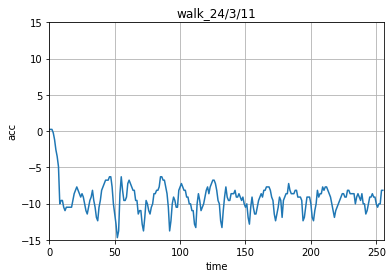

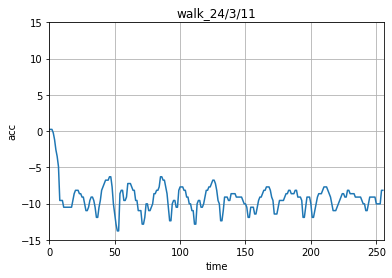

In [ ]:
# Testing the process 
# raw data plot 
b.plot_data("acc", "time", "walk_24/3/11",df1[(df1['date_time']=='2011-03-24-09-51-07') & (df1['cat']=='walk')]['X'].values)
# clean data 
a = b.remove_noise(df1[(df1['date_time']=='2011-03-24-09-51-07') & (df1['cat']=='walk')]['X'])
b.plot_data("acc", "time", "walk_24/3/11", a)


In [ ]:
# sequential cleaning of data (2min processing time)
b.sequence_cleaner()

In [ ]:
b.df


,X,Y,Z,subject_id,cat,date_time
0,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
1,2.101286,5.836905,7.704714,f1,pour_water,2011-03-24-10-51-12
2,2.101286,5.836905,8.171667,f1,pour_water,2011-03-24-10-51-12
3,2.101286,5.369952,8.171667,f1,pour_water,2011-03-24-10-51-12
4,2.101286,5.836905,8.171667,f1,pour_water,2011-03-24-10-51-12
...,...,...,...,...,...,...
143867,-6.303857,2.101286,7.237762,f5,getup_bed,2012-06-20-20-30-45
143868,-6.303857,2.101286,6.770810,f5,getup_bed,2012-06-20-20-30-45
143869,-6.303857,2.101286,6.303857,f5,getup_bed,2012-06-20-20-30-45
143870,-6.770810,2.101286,6.303857,f5,getup_bed,2012-06-20-20-30-45


In [ ]:
# extracting features 

b.feature_extraction()


In [ ]:
len(b.x_fft_cat['walk'])
len(b.x_fft_cat['getup_bed'])

101

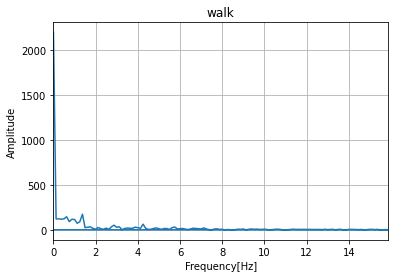

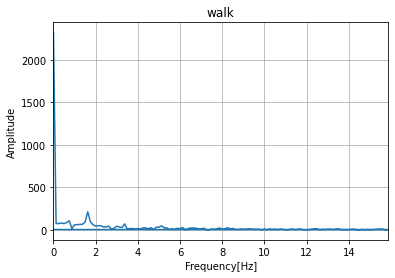

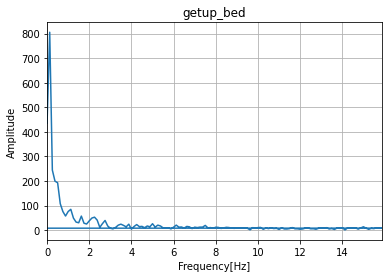

In [ ]:
b.plot_FFT('walk', 2, 'X')
b.plot_FFT('walk', 1, 'X')
b.plot_FFT('getup_bed', 2, 'X')

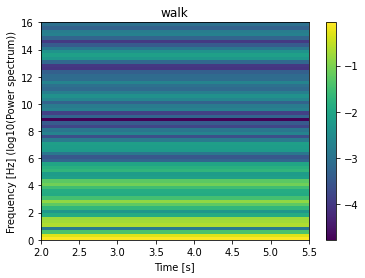

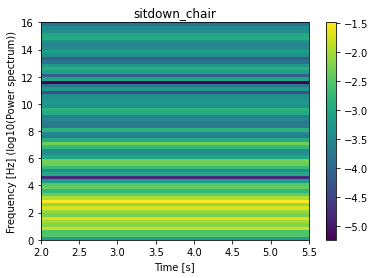

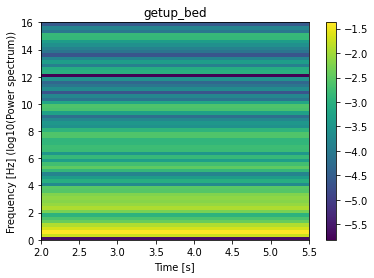

In [ ]:
b.Spectrogram_plotter('walk', 2, 'X')
b.Spectrogram_plotter('sitdown_chair', 2, 'X')
b.Spectrogram_plotter('getup_bed', 2, 'X')

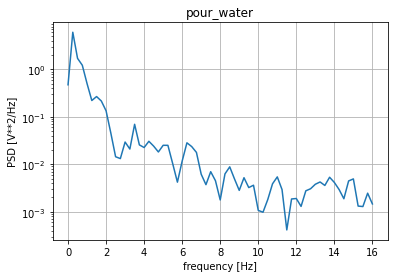

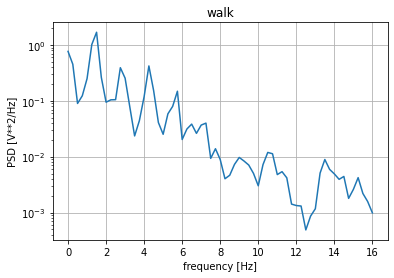

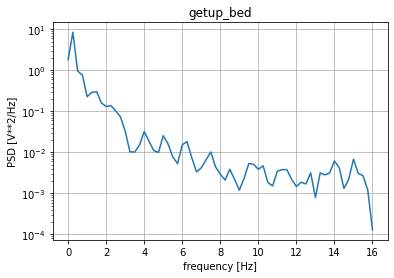

In [ ]:
#print(df1[df1['date_time']=='2011-03-24-13-56-42']['Y'])
b.PSD_plotter('pour_water', 2, 'X')
b.PSD_plotter('walk', 2, 'X')
b.PSD_plotter('getup_bed', 2, 'X')

In [ ]:
# Models (yet to be implemented)
# link : https://github.com/qiuqiangkong/audioset_tagging_cnn/blob/master/pytorch/models.py (PANN)

BATCH_SIZE = 16
class Conv2D1(pl.LightningModule):
  def __init__(self, input_size, output_size):
    super(Conv2D1, self).__init__()
    self.cv1 = nn.Conv2d(in_channels=input_size, out_channels=output_size,
                           kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
    self.cv2 = nn.Conv2d(in_channels=output_size, out_channels=output_size,
                           kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
    self.bn1 = nn.BatchNorm2d(output_size)
    self.bn2 = nn.BatchNorm2d(output_size)
    # doubt: initializing the weights 

  def forward(self, input):
    x = input
    x = nn.functional.relu_(self.bn1(self.cv1(x)))
    x = nn.functional.relu_(self.bn2(self.cv2(x)))
    '''if pool_type == 'max':
      x = nn.fucntional.max_pool2d(x, pool_size)
    elif pool_type == 'avg':
      x = nn.functional.avg_pool2d(x, pool_size)
    elif pool_type == 'avg+max':
      x1 = nn.fucntional.max_pool2d(x, pool_size)
      x2 = nn.functional.avg_pool2d(x, pool_size)
      x = x1 + x2 # merge and run ? '''
    return x 

class CNN14(pl.LightningModule):
  def __init__(self, train, test, val, obj):
    super(CNN14, self).__init__()
    # doubt: Mel filter bank and Spectrogram specs
    self.bn0 = nn.BatchNorm2d(64)
    self.conv_block1 = Conv2D1(3, 64)
    self.conv_block2 = Conv2D1(64, 128)
    self.conv_block3 = Conv2D1(128, 256)
    self.conv_block4 = Conv2D1(256, 512)
    self.conv_block5 = Conv2D1(512, 1024)
    self.conv_block6 = Conv2D1(1024, 2048)
    self.fc1 = nn.Linear(2048, 2048, bias=True)
    self.fc_2 = nn.Linear(2048, 7, bias=True)
    self.loss = nn.CrossEntropyLoss()
    self.accuracy = Accuracy()
    self.train_ds = train
    self.test_ds = test
    self.val_ds = val
    self.obj_prep = obj
    self.plotter_acc = []
    self.plotter_loss = []
 
  def eval_ip(self, x):
    a = np.empty((3, 64, 2))
    inp = []
    dic_index = {0:'pour_water', 1:'climb_stairs', 2:'sitdown_chair',
                                3:'walk', 4:'standup_chair', 5:'drink_glass', 6:'getup_bed' }
    for seq, cat in x:
      a = np.hstack((self.obj_prep.x_spec_cat[dic_index[cat.item()]][seq.item()][-1],
                    self.obj_prep.y_spec_cat[dic_index[cat.item()]][seq.item()][-1],
                    self.obj_prep.z_spec_cat[dic_index[cat.item()]][seq.item()][-1])).astype(np.float32)
     
      a = torch.from_numpy(a).cuda()
      
      inp.append(a)
    
    return torch.cat(inp)
    
  def forward(self, x):
    # operations with input 
    x = self.eval_ip(x)
    x = x.reshape((-1, 3, 65, 2)) # batch_number * 3 channels(X, Y, Z) * ( 65 * 2) spectrogram data
    x = self.conv_block1(x)
   
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    
    x = self.conv_block4(x)
    
    x = self.conv_block5(x)
    
    x = self.conv_block6(x)
   
    # global pooling 
    x = torch.mean(x, dim=3)
    (x1, _) = torch.max(x, dim=2)
    x2 = torch.mean(x, dim=2)
    x = x1 + x2 # merge and run?? 
    x = nn.functional.dropout(x, p=0.5, training=self.training)
    x = nn.functional.relu_(self.fc1(x))
    clipwise_output = torch.sigmoid(self.fc_2(x))
    return x
  
  def training_step(self, batch, batch_idx): 
    x, y = batch
    x = x.reshape(x.shape[0], -1) 
    l = self.forward(x) # logit 
    J = self.loss(l, y)
    self.plotter_loss.append(J)
    self.log("train_loss", J, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    
    return J
  
  def configure_optimizers(self):         # Optimizer
    opt = torch.optim.SGD(self.parameters(), lr = 1e-2)
    return opt
  
  def validation_step(self, batch, batch_idx, print_str="val"):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss(logits, y)
    preds = torch.argmax(logits, dim=1)
    self.accuracy(preds, y)
    self.log(f"{print_str}_loss", loss, prog_bar=True, enable_graph=True)
    self.log(f"{print_str}_acc", self.accuracy, prog_bar=True, enable_graph=True)
    self.plotter_acc.append(self.accuracy)
    return loss

  def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx,print_str='test')
  
  def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=BATCH_SIZE,shuffle=True)

  def val_dataloader(self):
      return DataLoader(self.val_ds, batch_size=BATCH_SIZE,shuffle=False)

  def test_dataloader(self):
      return DataLoader(self.test_ds, batch_size=BATCH_SIZE,shuffle=False)

    
'''
hyperparameter tunig see: automl, grid search 
modify the CNN14 model 
'''



'\nhyperparameter tunig see: automl, grid search \nmodify the CNN14 model \n'

Map : []

In [ ]:
class DataModule(Dataset):
    def __init__(self, obj):
        super().__init__()
        self.df = pd.DataFrame(columns = ['id', 'cat'])
        for i in obj.x_spec_cat.keys():
          if len(self.df)==0:
            self.df['id'] = pd.DataFrame(range(0, len(obj.x_spec_cat[i])))
            self.df['cat'] = i
          else:
            f = pd.DataFrame(columns = ['id', 'cat'])
            f['id'] = pd.DataFrame(range(0, len(obj.x_spec_cat[i])))
            f['cat'] = i
            self.df = self.df.append(f)
        self.df = self.df.sample(frac = 1) # jumbling data
        self.df.reset_index(inplace=True, drop=True)
        self.df_labels = pd.get_dummies(self.df['cat'])
        train_split=0.6
        val_split=0.8
        self.df['cat'].replace({'pour_water':0, 'climb_stairs':1, 'sitdown_chair':2,
                                'walk':3, 'standup_chair':4, 'drink_glass':5, 'getup_bed':6 }, inplace=True)
       
        self.train, self.val, self.test = np.split(self.df, [int(train_split*len(self.df)), int(val_split*len(self.df))])
        self.train_labels, self.val_labels, self.test_labels = np.split(self.df_labels, [int(train_split*len(self.df)), int(val_split*len(self.df))])
    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self, index):
        return self.dataset[index], self.labels[index]

    def set_fold(self, type):
      if type=='TRAIN':
          self.dataset,self.labels=self.train,self.train_labels
      if type=='TEST':
          self.dataset,self.labels=self.test,self.test_labels
      if type=='VAL':
          self.dataset,self.labels=self.val,self.val_labels
     
      self.dataset=torch.tensor(self.dataset.to_numpy())
      self.labels=torch.tensor(self.labels.to_numpy().reshape(-1)).long()
      
      return self

In [ ]:

class DataModule2(Dataset):
   def __init__(self, obj):
      super().__init__()
      self.obj = b
   
   def __getitem__(self, idx):
     pass
      


In [ ]:
dataset = DataModule(b)


In [ ]:
train=copy.deepcopy(dataset).set_fold('TRAIN')
test=copy.deepcopy(dataset).set_fold('TEST')
val=copy.deepcopy(dataset).set_fold('VAL')

In [ ]:
trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    devices = 1,
    accelerator = 'gpu'
)
# Define the Model
model=CNN14(train, test, val, b)
# Train the Model
trainer.fit(model)
# Test on the Test SET, it will print validation
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type             | Params
--------------------------------------------------
0  | bn0         | BatchNorm2d      | 128   
1  | conv_block1 | Conv2D1          | 38.8 K
2  | conv_block2 | Conv2D1          | 221 K 
3  | conv_block3 | Con

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_13/checkpoints/epoch=9-step=220.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_13/checkpoints/epoch=9-step=220.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8584070801734924
        test_loss            0.438043475151062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8584070801734924, 'test_loss': 0.438043475151062}]

In [ ]:
trainer.validate()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `validate(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_13/checkpoints/epoch=9-step=220.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_13/checkpoints/epoch=9-step=220.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8571428656578064
        val_loss            0.8083109855651855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.8571428656578064, 'val_loss': 0.8083109855651855}]